## Wstęp do uczenia maszynowego 
### Praca domowa 5
#### Jakub Piwko, Malwina Wojewoda 
zespół walidujący Patryka Rakusa i Łukasza Tomaszewskiego
***

### Pakiety

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster import hierarchy
from sklearn import cluster, datasets, mixture
from sklearn_extra.cluster import KMedoids
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

### Wczytanie i analiza danych

In [2]:
X = pd.read_csv('urbanGB.txt', names = ['x','y'], header=None)

In [3]:
X.head()

,x,y
0,-0.310990,53.7802
1,-3.112550,55.8706
2,-0.088533,51.3806
3,-0.326795,51.4476
4,-3.946530,51.6594


Jako, że mamy do czynienia ze współrzędymi kartograficznymi, odlegości między punktami, które będziemy obliczać mogą być nieprecyzyjne ze względu na zakrzywienie ziemi. W opisie danych dodano wskazówkę, aby przemnożyć dlugość geograficzną przez wskaźnik 1.7, aby uzyskać najbardziej przybliżone odległości. 

Budowniczy nie zdecydowali się na ten krok, dlatego my spróbujemy dokonać zmian, aby porównać wyniki. 

In [4]:
X.x = 1.7 * X.x

In [5]:
X.head()

,x,y
0,-0.528683,53.7802
1,-5.291335,55.8706
2,-0.150506,51.3806
3,-0.555551,51.4476
4,-6.709101,51.6594


In [6]:
X = X.to_numpy()

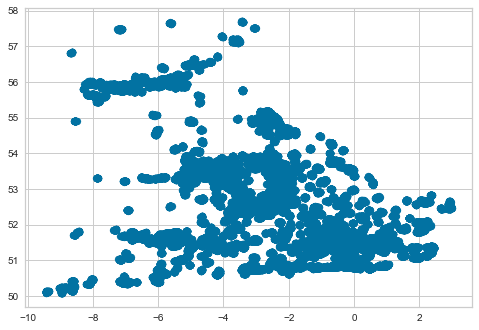

In [7]:
plt.scatter(X[:,0],X[:,1])
plt.show()

### KMean i metoda łokcia 

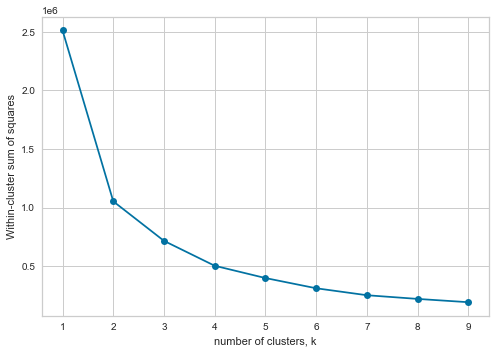

In [8]:
ks = range(1, 10)
scores = []

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(X)
    scores.append(model.score(X) * -1)
    
plt.plot(ks, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(ks)
plt.show()

Budowniczy wykorzystali metodą łokcia do znalezienia optymalnej liczby klastrów. Według ich interepretacji, punkt przegięcia i tym samym podział wypada dla liczby klastrów 4 lub 5. My sprawdzimy jeszcze dla wartości 3.

In [9]:
def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means clusters')
    plt.show()

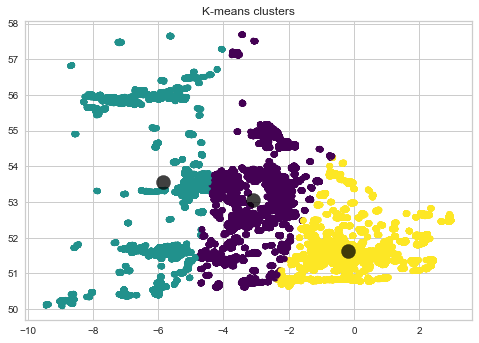

In [10]:
plot_kmeans_clusters(X, n_clusters=3)

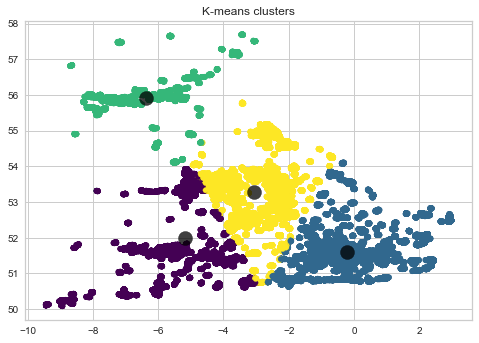

In [11]:
plot_kmeans_clusters(X, n_clusters=4)

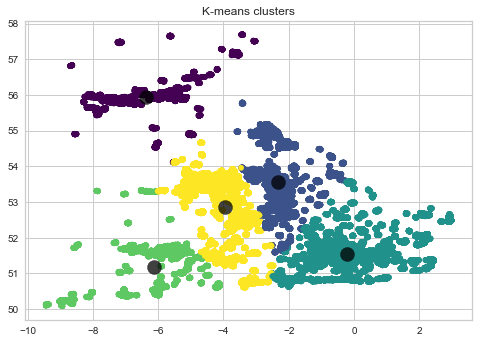

In [12]:
plot_kmeans_clusters(X, n_clusters=5)

Po przeskalowaniu długości geograficznej można dostrzec, że klastry zbudowały się odrobinę inaczej. Nadal aktualny jest wniosek, że 4 i 5 klastrów dzieli lepiej punkty w grupy.

#### Metoda silhouette
Dodatkowo, spróbujemy jeszcze zbadać optymalną liczbę klastrów metodą silhouette. Ze względu na dużą złożoność obliczeniową spróbujemy przeprowadzić dobór na zmniejszonym zbiorze.

In [13]:
df = pd.DataFrame(X, columns=['x', 'y'])
df = df.sample(frac=0.1, random_state=42).astype('float32')

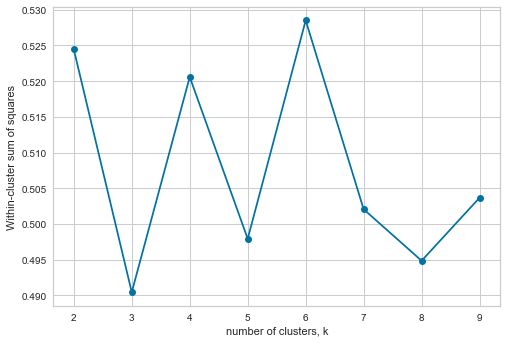

In [14]:
ks = range(2, 10)
scores = []

for k in ks:
    model = KMeans(n_clusters = k)
    labels = model.fit_predict(df)
    scores.append(silhouette_score(df, labels))
    
plt.plot(ks, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(ks)
plt.show()

Metoda silhouette nie daje wyraźnych wyników, prawdopodobnie dlatego, że większość rozważanych przez nas punktów jest blisko siebie. Spróbujmy to zwizualizować jeszcze w inny sposób:

In [15]:
#!pip install yellowbrick

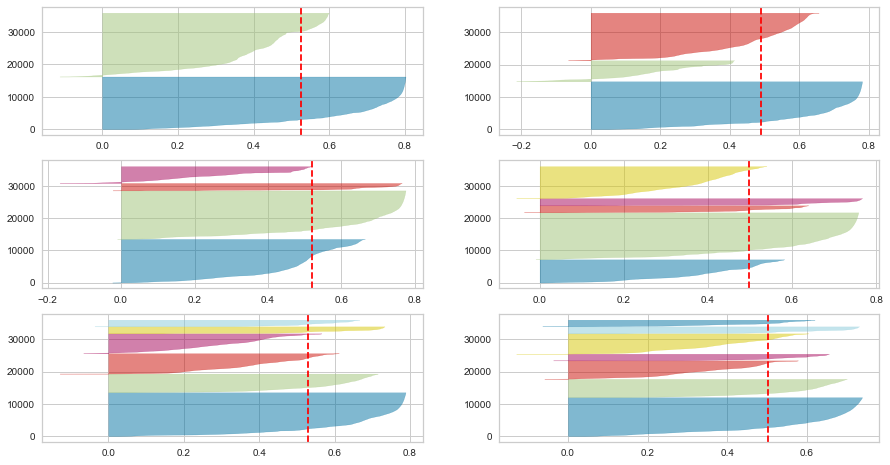

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)

Z powyższych wykresów również nie widać wyraźnie jaka liczba kastrów byłaby najodpowiedniejsza. Możemy więc uznać że w przypadku naszego zbioru te metoda jest nieefektywna.

### Klasteryzacja hierarchiczna

Budowniczy wykorzystali metodę aglomeracyjną. Ona także ma dużą złożoność obliczeniową, więc wykorzystamy pomniejszony zbiór, wylosowany tak samo jak w ich przypadku, aby sprawdzić czy skalowanie zmiennych daje duże różnice. 

In [17]:
df = pd.DataFrame(X, columns=['x', 'y'])
df = df.sample(frac=0.05, random_state=42).astype('float32')

In [18]:
Z = hierarchy.linkage(df, method='ward')

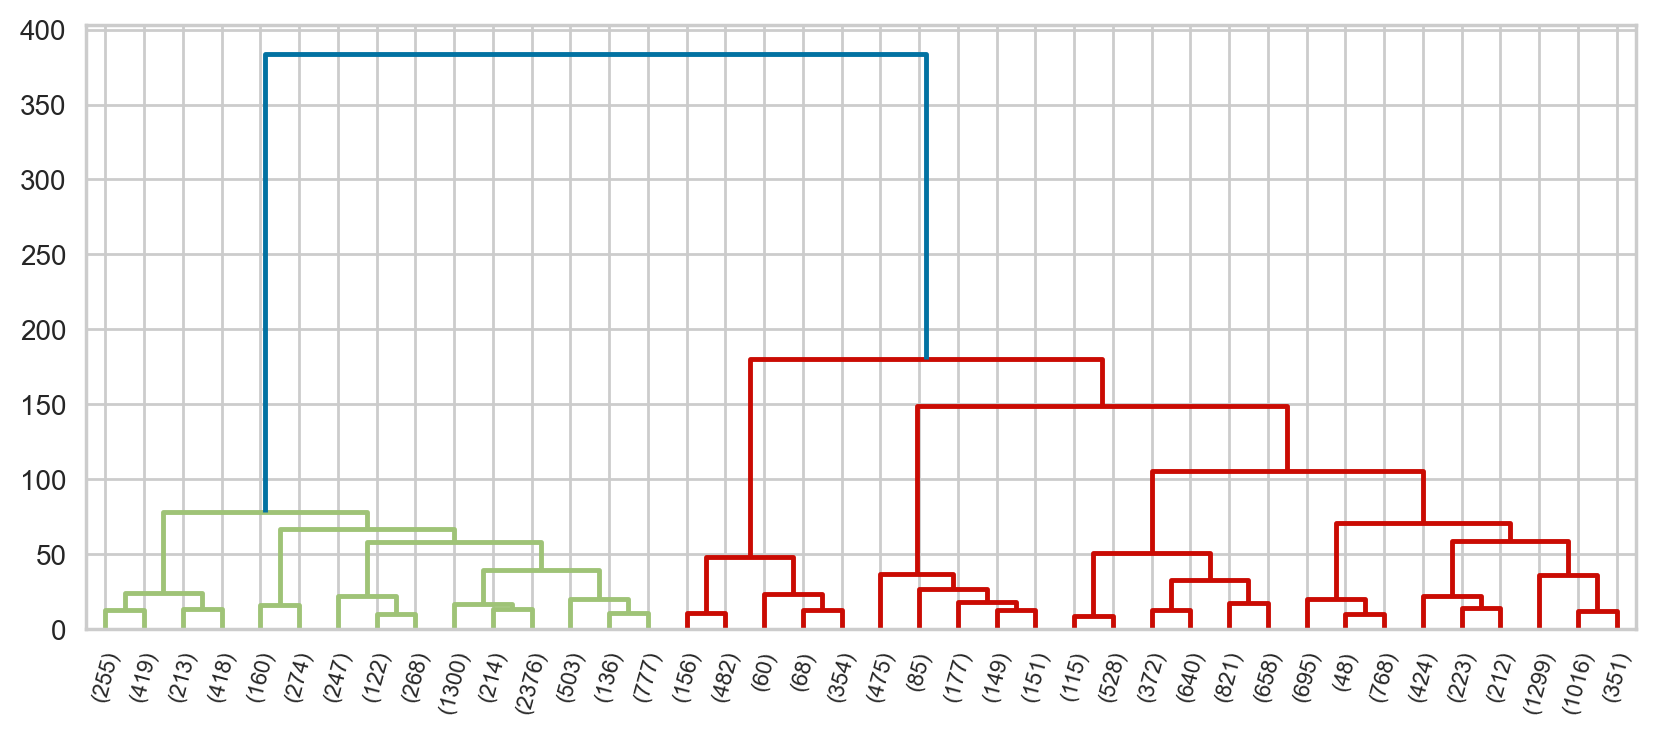

In [19]:
plt.figure(figsize=(10, 4), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z, p=40, truncate_mode='lastp', leaf_rotation=75)
plt.show()

Wnioski są podobne, że najlepiej podzielić nasz zbiór na 4 lub 5 klastrów, również po przeskalowaniu. 

Budowniczy zdecydowali się w kolejnym kroku na klasteryzację aglomeracyjną z wykorzystaniem progu odległości. 

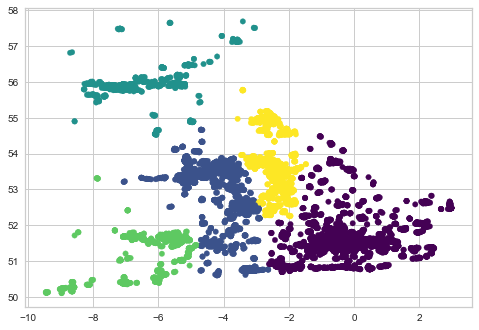

In [20]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=100, linkage='ward')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Bez skalowania dla threshold równego 100 budowniczy uzyskali 4 klastry, po skalowaniu jest ich 5.

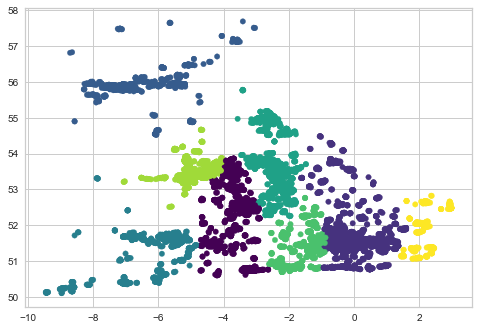

In [21]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=60, linkage='ward')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Przy progu wynoszącym 60 dla naszych danych model wyznaczył aż 8 klastrów. U budwoniczych było tylko 5. Pokazuje to, że dla metody z ustawianiem thresholdu duże znaczenie ma przeskalowanie długości geograficznej. W naszym przypadku lepiej byłoby wybrać większe wartości progu.

Budowniczy w swoim raporcie wykorzystali aglomeracyjną metodą klasteryzacji z połączeniem typu 'ward'. My spróbujemy jeszcze hierarchizacji dla 5 klastrów z połączeniem typu: 'complete', 'average' i 'single'.

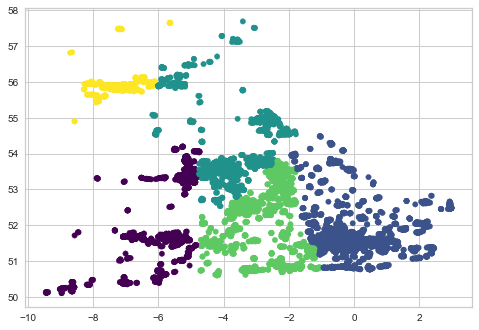

In [22]:
model = AgglomerativeClustering(n_clusters=5, linkage='complete')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

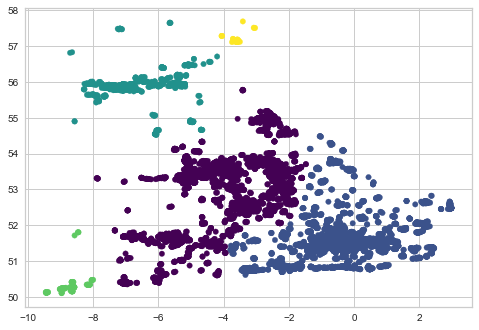

In [23]:
model = AgglomerativeClustering(n_clusters=5, linkage='average')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

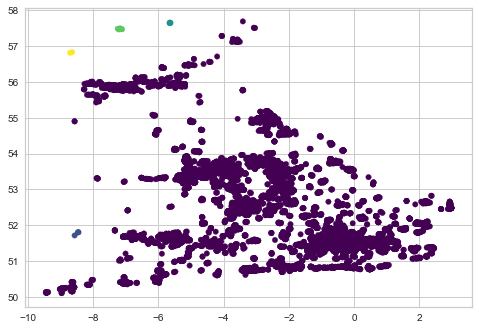

In [24]:
model = AgglomerativeClustering(n_clusters=5, linkage='single')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Widać, że wybór 'ward' w metodzie łączenia przez budowniczych było uzasadnione bo inne metody łączą w nieproporcjonalne klastry lub klastry, które nie pokrywają się z faktycznym położeniem grup na wykresie. 

### K-medoids oraz metoda łokcia

Mimo, że w budowie nie została wykorzystana ta metoda uznaliśmy, że warto też przetesować jakie dałaby wyniki. W tym przypadku również wykorzystamy mniejszą próbkę danych.

In [25]:
df = pd.DataFrame(X, columns=['x', 'y'])
df = df.sample(frac=0.05, random_state=42).astype('float32')

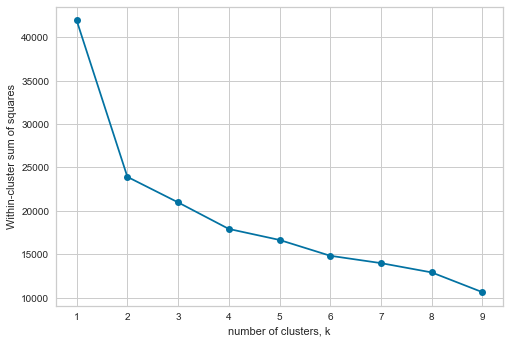

In [26]:
ks = range(1, 10)
scores = []
for k in ks:
    model =  KMedoids(n_clusters = k)
    model.fit(df)
    scores.append(model.inertia_)
plt.plot(ks, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(ks)
plt.show()

Z powyższego wykresu trudno wybrać, która liczba będzie najodpowiedniejsza. Jako kandydatów wybieramy 2, 4 oraz 6.

In [27]:
def plot_kmedoids_clusters(X, n_clusters):
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=0)
    kmedoids.fit(X)
    y_kmedoids = kmedoids.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmedoids, s=30, cmap='viridis')

    centers = kmedoids.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-medoids clusters')
    plt.show()

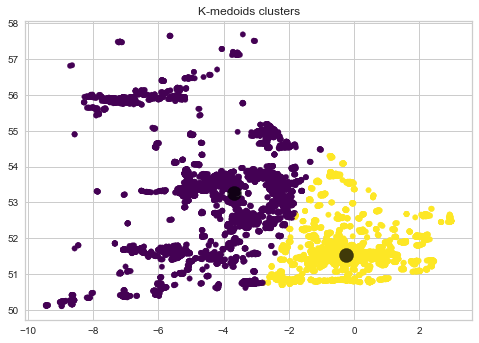

In [28]:
plot_kmedoids_clusters(df.to_numpy(), n_clusters=2)

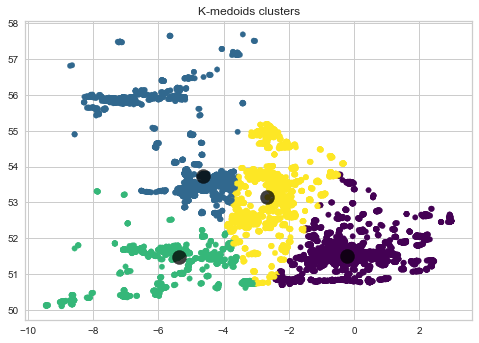

In [29]:
plot_kmedoids_clusters(df.to_numpy(), n_clusters=4)

Zobaczmy jeszcze jak będzie to wyglądało w przypadku 6 klastrów:

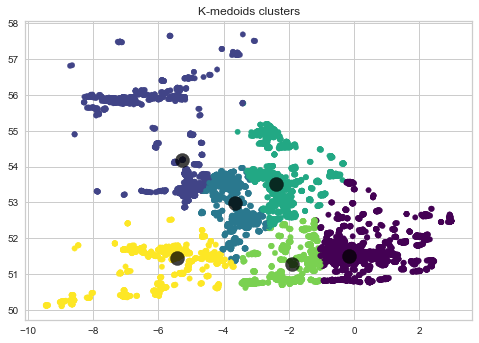

In [30]:
plot_kmedoids_clusters(df.to_numpy(), n_clusters=6)

### K-medroids i indeks Daviesa–Bouldina
Skoro metoda łokcia nie dała wyraźnego wskazania, jaka liczba klastrów jest najbardziej odpowiednia spróbujemy skorzystać z indeksu Daviesa–Bouldina.

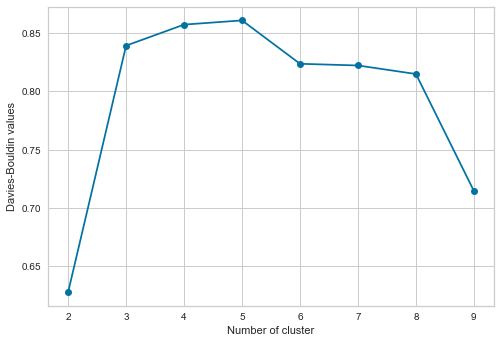

In [31]:
ks = range(2, 10)
scores = []
for k in ks:
    model = KMedoids(n_clusters = k, random_state=10)
    labels = model.fit_predict(df)
    scores.append(davies_bouldin_score(df, labels))

plt.plot(ks, scores, '-o')
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.xticks(ks)
plt.show()

Z powyższego wykresy wynika, że najodpowiedniejsza liczba to 4 lub 5. Dla 4 już sprawdzaliśmy, zobaczmy więc jak to wygląda  w przypadku pięciu:

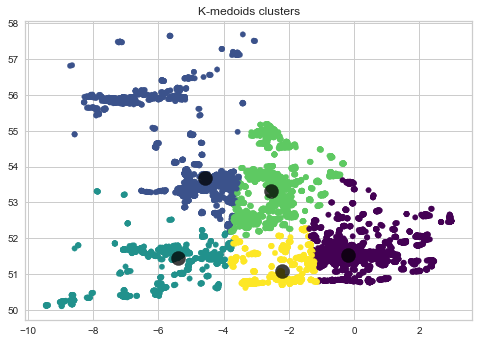

In [32]:
plot_kmedoids_clusters(df.to_numpy(), n_clusters=5)

### DBSCAN

Sprawdzimy jeszcze jak z klasteryzacją poradzi sobie DBSCAN. Najpierw znajdziemy optymalną wartość parametru epsilon.

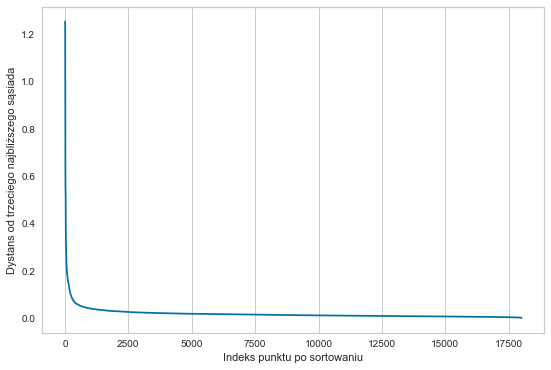

In [33]:
minPts = 5
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(df)
distances, indices = nbrs.kneighbors(df)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,df.shape[0]+1)), distanceDec)

#plt.xscale('log')

plt.grid(axis='y')

plt.show()

Wydaje się, że odpowiedni punkt przegięcie, a więc i epsilon mieści się między wartościami 0.0 i 0.2. Metodą prób i błędów można stwierdzić, że epsilon równy 0.15 daje najlepszy rezultat.

In [34]:
eps = 0.15

dbs = cluster.DBSCAN(eps=eps, min_samples=minPts)
dbs.fit(df)

#df = df.to_numpy()
y_pred = dbs.labels_.astype(np)

plt.scatter(df[:,0],df[:,1],c=y_pred, cmap='viridis')
plt.show()

C:\Users\wojew\AppData\Local\Temp/ipykernel_10896/1970720939.py:7: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  y_pred = dbs.labels_.astype(np)


TypeError: '(slice(None, None, None), 0)' is an invalid key

W klasteryzacji DBSCAN można wyróżnić 3 istotne grupy w odcieniach ciemnego fioletu. Reszta punktów jest podzielona na wiele mniejszych klastrów, które potraktował jak szumy. Wykres różni sie znacznie od tych z poprzednich modeli. 

![](mapa1.png)

Porównując mapę klastrów z mapą drogową Wielkiej Brytanii można zauważyć, że ciemnofioletowe grupy wyodrębnione przez DBSCAN pokryają się z lokalizacją największych miast Wielkiej Brytanii, np. Londynu, Birmingham, Manchaster i Glasgow. Może to nasuwać wniosek, że najwięcej wypadków drogowych dzieje się tam, gdzie ruch samochodowy jest największy, czyli w większych aglomeracjach. 

## Podsumowanie
Główną zmianą, którą wprowadziliśmy było przesklalowanie długości geograficznej przez wskaźnik 1.7, jak było zalecona w opisie ramki danych. Wykorzystując KMeans ora metodę łokcia wyszedł nam taki sam wniosek jak grupie budującej: najlepiej wybrać 4 lub 5 klastrów. Metoda silhouette się w tym przypadku nie sprawdziła. 

W przyapdku metody aglomeracyjnej grupa budująca otrzymała podział zbioru na 4 klastry, a my, po sklaowaniu, na 5 klastrów. Sprawdziliśmy następnie jak wpłnie na podział zmiana typu połączenia klastrów, jednak pierwotnie wykorzystana - *ward* - okazała się najlepsza. 

Przetestowaliśmy także metodę K-medoids i ponownie do wyboru liczby klastrów wykorzystaliśmy metodę łokcia, która wcześniej okazała się bardziej efektywna niż silhouette. Tym razem nie wskazała ona wyraźnego wyniku, jednak z analizy wykresów wydaje się, że 4 to najlepszy wybór. Sprawdziliśmy też indeks Daciesa-Bouldina, który wskazał, że najlepiej wybrać 4 lub 5 klastrów.

Na końcu wykorzystalismy model DBSCAN. Przy optymalnej wartości epsilona, na uzyskanej mapie punktów udało się wyodrębnić istotne klastry. Okazuje się, że owe klastry są powiązane z dużymi miastami.

Wyszystkie metody dały dość podobny podział zbioru na klastry, poza DBSCAN. Jest to jedyny model, którego klasteryzacja pozwoliła nam dogłębniej przeanalizować wynik i powiązać go z czynnikami geograficznymi Wielkiej Brytanii. Możemy więc uznać, że jest to najlepszy model dla tego problemu